In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
import sqlite3 as db
#import geopy
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [4]:
github_userName = 'Tanag3r'
ebird_token = 'j6c7l80ga2ib'
db_name = 'trailheadDirectBirds_sous.db'

In [5]:
##connect to database
def connectDB():
    try:
        cnx = db.connect(db_name)
    except Exception as cnxError:
        raise UserWarning(f'Unable to connect to database due to: {cnxError}')
    return cnx

In [6]:
def stopQualityMask(speciesCode: str,closestStop: str):
    cnx = connectDB()
    try:
        gap = dt.date.today().year-2018
        query = f'SELECT COUNT(DISTINCT(year)) as "frq" FROM coefficients_bySpecies WHERE speciesCode = "{speciesCode}" AND closestStop = "{closestStop}"'
        coeficients = pd.read_sql(query,con=cnx)
        coeficients['frq'] = coeficients.apply(lambda g: (g.frq/gap),axis=1)
    except Exception as maskExc:
        raise maskExc
    return coeficients['frq']

In [36]:
def weeklyAbundance():
    cnx = connectDB()
    try:
        #note that the query filters out birds only seen by two people
        ObsDataset = pd.read_sql('SELECT speciesCode,FX.locId,StopName,obsDt,howMany,subId FROM historicObservations AS FX  LEFT JOIN closestStop on FX.locId = closestStop.locId WHERE (SELECT count(distinct(subId)) FROM historicObservations AS QA WHERE QA.speciesCode = FX.speciesCode) > 2;',con=cnx,parse_dates=['obsDt']) #Canada Jay filter is for testing purposes only
        ObsDataset['obsDt_week'] = ObsDataset['obsDt'].dt.isocalendar().week
        ObsDataset['howMany'] = ObsDataset['howMany'].fillna(1)
    #group up data
        ObsDataset = ObsDataset.groupby(['speciesCode','StopName','locId','obsDt_week'])['howMany'].mean().reset_index()
        maxCount = ObsDataset.groupby(['speciesCode'])['howMany'].max()
    #calculations
        ObsDataset['relativeAbundance'] = ObsDataset.apply(lambda x: (x.howMany/(maxCount[x.speciesCode])),axis=1)  #baseline
        ObsDataset['relativeAbundance'] = ObsDataset.apply(lambda f: stopQualityMask(f.speciesCode,f.StopName)*f.relativeAbundance,axis=1)  #apply frequency mask
        maxAbd = ObsDataset.groupby(['speciesCode'])['relativeAbundance'].max() #max abundance value by species
        minAbd = ObsDataset.groupby(['speciesCode'])['relativeAbundance'].min()   #min abundance value by species
        ObsDataset['relativeAbundance'] = ObsDataset.apply(lambda n: ((n.relativeAbundance-minAbd[n.speciesCode])/(maxAbd[n.speciesCode]-minAbd[n.speciesCode])),axis=1)  #min-max normalize
    #mask back in sightings of single birds seen once in a week
        ObsDataset['singletonMask']= ObsDataset.apply(lambda s: (maxAbd[s.speciesCode] == maxAbd[s.speciesCode]) and (s.howMany == maxCount[s.speciesCode]),axis=1)
        ObsDataset.loc[ObsDataset['singletonMask'] == True,'relativeAbundance'] = 1
        ObsDataset.sort_values(by=['speciesCode','obsDt_week'],ascending=True,inplace=True)
    #apply absence smoothing mask
        list = []
        ObsDataset = ObsDataset.groupby(['speciesCode','obsDt_week'])['relativeAbundance'].mean().reset_index()
        speciesKeys = ObsDataset.drop_duplicates(subset=['speciesCode'])
        for speciesCode in speciesKeys.itertuples():
            species_obsDataset = ObsDataset[ObsDataset['speciesCode']==speciesCode.speciesCode]
            #weekMin = (species_obsDataset['obsDt_week'].min()-8)
            #if weekMin <= 0: weekMin = 1
            #weekMax = (species_obsDataset['obsDt_week'].max()+8)
            #if weekMax > 53: weekMax = 53
            #allweek = pd.DataFrame({'obsDt_week':range(weekMin,weekMax)})
            allweek = pd.DataFrame({'obsDt_week':range(1,53)})
            species_obsDataset.drop(columns=['speciesCode'],inplace=True)
            species_obsDataset = pd.merge(left=species_obsDataset,right=allweek,left_on='obsDt_week',right_on='obsDt_week',how='outer')
            species_obsDataset.set_index('obsDt_week',inplace=True)
            species_obsDataset.sort_index(axis='index',ascending=True,inplace=True)
            species_obsDataset['mask'] = species_obsDataset['relativeAbundance'].interpolate(method='index',limit=5,limit_direction='both')  #mask, values do not matter
            species_obsDataset.loc[species_obsDataset['mask'].isna() == True,'relativeAbundance'] = 0
            species_obsDataset.reset_index(inplace=True)
            species_obsDataset['speciesCode'] = speciesCode.speciesCode
            list.append(species_obsDataset)
        weeklyAbd = pd.DataFrame(pd.concat(list,ignore_index=True))
    except Exception as calcEx:
        raise calcEx
    finally: cnx.close()
    #return weeklyAbd[['speciesCode','StopName','obsDt_week','locId','relativeAbundance']]
    return weeklyAbd

In [24]:
##TODO #82 write a function that returns a dataframe of the annual relative abundance for a given list of birds
##TODO #84 add StopName as an optional argument for the function wklyAbd_setSpecies()
##TODO #86 replace comName with speciesCode in all functions
def wklyAbd_setSpecies(speciesList: list):
    cnx=connectDB()
    try:
        querySpecies = ",".join(speciesList)
        ##todo #83 write an exception to convert non-string speciesList values to strings that returns the db.error if the strings do not represent columns
        query = f'SELECT speciesCode,FX.locId,StopName,obsDt,howMany FROM historicObservations AS FX  LEFT JOIN closestStop on FX.locId = closestStop.locId WHERE (SELECT count(distinct(subId)) FROM historicObservations AS QA WHERE QA.comName = FX.comName) > 2 AND FX.comName in ({querySpecies});'
        obsData = pd.read_sql(query,con=cnx,parse_dates=['obsDt'])
        obsData = obsData.assign(obsDt_week=obsData.obsDt.dt.isocalendar().week)
        obsData['howMany'].fillna(1,inplace=True)
        obsData = obsData.groupby(['speciesCode','StopName','obsDt_week'])['howMany'].mean().reset_index()
        maxCount = obsData.groupby(['speciesCode'])['howMany'].max()
        #derive relative abundance
        obsData['relativeAbundance'] = obsData.apply(lambda x: (x.howMany/(maxCount[x.speciesCode])),axis=1)  #baseline
        obsData['relativeAbundance'] = obsData.apply(lambda f: stopQualityMask(f.speciesCode,f.StopName)*f.relativeAbundance,axis=1)  #apply frequency mask
        maxAbd = obsData.groupby(['speciesCode'])['relativeAbundance'].max() #max abundance value by species
        minAbd = obsData.groupby(['speciesCode'])['relativeAbundance'].min()   #min abundance value by species
        obsData['relativeAbundance'] = obsData.apply(lambda n: ((n.relativeAbundance-minAbd[n.speciesCode])/(maxAbd[n.speciesCode]-minAbd[n.speciesCode])),axis=1)  #min-max normalize


        #apply absence smoothing mask
        list = []
        obsData = obsData.groupby(['speciesCode','obsDt_week'])['relativeAbundance'].mean().reset_index()
        speciesKeys = obsData.drop_duplicates(subset=['speciesCode'])
        for speciesCode in speciesKeys.itertuples():
            species_obsData = obsData[obsData['speciesCode']==speciesCode.speciesCode]
            weekMin = (species_obsData['obsDt_week'].min()-8)
            if weekMin <= 0: weekMin = 1
            weekMax = (species_obsData['obsDt_week'].max()+8)
            if weekMax > 53: weekMax = 53
            allweek = pd.DataFrame({'obsDt_week':range(weekMin,weekMax)})
            species_obsData.drop(columns=['speciesCode'],inplace=True)
            species_obsData = pd.merge(left=species_obsData,right=allweek,left_on='obsDt_week',right_on='obsDt_week',how='outer')
            species_obsData.set_index('obsDt_week',inplace=True)
            species_obsData.sort_index(axis='index',ascending=True,inplace=True)
            species_obsData['mask'] = species_obsData['relativeAbundance'].interpolate(method='index',limit=5,limit_direction='both')  #mask, values do not matter
            species_obsData.loc[species_obsData['mask'].isna() == True,'relativeAbundance'] = 0
            species_obsData.reset_index(inplace=True)
            species_obsData['speciesCode'] = speciesCode.speciesCode
            list.append(species_obsData)
        weeklySpeciesAbd = pd.DataFrame(pd.concat(list,ignore_index=True))
    except db.DatabaseError as dbExc:
        raise f'there was an issue with the database request: {dbExc}'
    except Exception as ex:
        raise ex
    return weeklySpeciesAbd

In [ ]:
##TODO #80 develop a reference model for birds present in winter and early spring that returns a list of species that fit the model
##TODO #81 write a function that tests the fit of each species' observerd smoothed relative abundance against each model, then returns a model

#winter abundance model



In [37]:
allBirds = weeklyAbundance()

C:\Users\lukew\AppData\Local\Temp/ipykernel_11344/306523380.py:16: RuntimeWarning: invalid value encountered in double_scalars
  ObsDataset['relativeAbundance'] = ObsDataset.apply(lambda n: ((n.relativeAbundance-minAbd[n.speciesCode])/(maxAbd[n.speciesCode]-minAbd[n.speciesCode])),axis=1)  #min-max normalize
C:\Users\lukew\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
#interpolation testing
##TODO #87 turn block into a function that takes relative abundance values as and returns a list of like birds with the best interpolation method as an r2 score

speciesKeys = allBirds.drop_duplicates(subset=['speciesCode'])
helpList = []
weekSeries = pd.DataFrame(range(1,53),columns=['week'])
for speciesCode in speciesKeys.itertuples():
    winterGuy = allBirds[allBirds['speciesCode']== speciesCode.speciesCode].reset_index()
    winterGuy = winterGuy[['obsDt_week','relativeAbundance']].set_index('obsDt_week')
    winterGuy = winterGuy.interpolate(method='cubic',order=3,limit=5,limit_direction='both')
#normalize
    winterGuy_max = winterGuy['relativeAbundance'].max()
    winterGuy_min = winterGuy['relativeAbundance'].min()
    winterGuy['relativeAbundance'] = winterGuy['relativeAbundance'].apply(lambda n: ((n-winterGuy_min)/(winterGuy_max-winterGuy_min)))
    winterGuy.rename(columns={'relativeAbundance':f'{speciesCode.speciesCode}_cubic_3'},inplace=True)
    helpList.append(winterGuy)
    #results = pd.merge(right=weekSeries,right_on='week',left=winterGuy,left_on='obsDt_week',how='left')
results = pd.concat(helpList,axis=1)
results = results.fillna(value=0,axis=0)
#results = results.fillna(method='ffill',axis=0)
results.head(10)

##goal output for this function is a dictionary: 
#goals = ({'leadSpecies':'pasfly','method':'polynomial','order':3,'explains':[{'btywar':-1.059640118399928},{'rufhum':-0.04706819541929441},{'warvir':0.4480046324671728}]})

,amecro_cubic_3,amedip_cubic_3,amegfi_cubic_3,amepip_cubic_3,amerob_cubic_3,amewig_cubic_3,annhum_cubic_3,baleag_cubic_3,barswa_cubic_3,batpig1_cubic_3,...,westan_cubic_3,wewpew_cubic_3,whcspa_cubic_3,wilfly_cubic_3,wilsni1_cubic_3,wlswar_cubic_3,wooduc_cubic_3,y00475_cubic_3,yelwar_cubic_3,yerwar_cubic_3
obsDt_week,,,,,,,,,,,,,,,,,,,,,
1,0.090962,0.11172,1.000000,0.256334,0.425016,0.000000,0.625000,0.229222,0.152659,0.680193,...,0.479176,0.028346,0.105266,0.0,0.000000,0.0,0.000000,0.000000,0.086799,0.098643
2,1.000000,0.11172,0.606369,0.256334,0.023099,0.340512,0.500000,0.237955,0.152659,0.680193,...,0.479176,0.028346,0.105266,0.0,0.000000,0.0,0.000000,0.200220,0.086799,0.098643
3,0.079225,0.11172,0.323035,0.256334,0.315682,0.359953,0.187500,0.116817,0.152659,0.680193,...,0.479176,0.028346,0.105266,0.0,0.000000,0.0,0.000000,0.191027,0.086799,0.098643
4,0.114437,0.11172,0.136517,0.256334,0.785355,1.000000,1.000000,0.116817,0.152659,0.680193,...,0.479176,0.028346,0.105266,0.0,0.000000,0.0,0.470419,0.191027,0.086799,0.098643
5,0.179724,0.11172,0.033333,0.256334,0.270447,0.277405,0.550000,0.409070,0.152659,0.680193,...,0.479176,0.028346,0.105266,0.0,0.004254,0.0,0.461538,0.207115,0.086799,0.093986
6,0.287192,0.11172,0.000000,0.256334,0.593966,0.102738,0.500000,0.678842,0.152659,0.680193,...,0.479176,0.028346,0.105266,0.0,0.008850,0.0,0.269231,0.279892,0.086799,0.088918
7,0.042254,0.11172,0.023036,0.256334,0.338781,0.310903,0.334375,0.442792,0.152659,0.680193,...,0.479176,0.028346,0.131540,0.0,0.012203,0.0,0.153846,0.215541,0.086799,0.090370
8,0.035211,0.11172,0.088958,0.256334,0.354180,0.162555,0.583333,0.641374,0.152659,0.678968,...,0.479176,0.028346,0.179878,0.0,0.014448,0.0,0.153846,0.164356,0.086799,0.105272
9,0.004401,0.11172,0.184284,0.256334,0.554368,0.766712,0.604167,0.432300,0.152659,0.677761,...,0.479176,0.028346,0.236018,0.0,0.015721,0.0,0.115385,0.164705,0.086799,0.140554


In [39]:
fit = [(species,r2_score(results.pasfly,results[species])) for species in list(results)]
fit_df = pd.DataFrame(np.array(fit),columns=['species','r_squared'])
fit_df.sort_values(by='r_squared',ascending=True)
fit_df


AttributeError: 'DataFrame' object has no attribute 'pasfly'

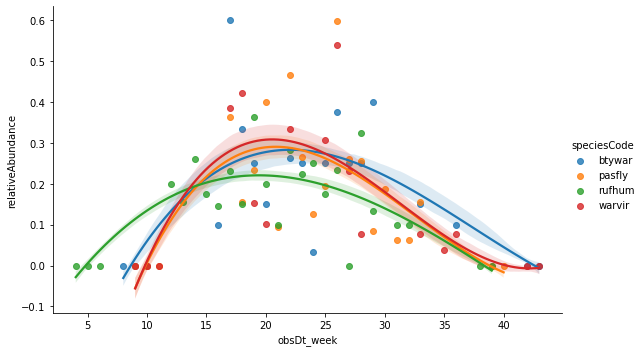

In [729]:
model___springSummer = wklyAbd_setSpecies(speciesList=['"Purple Martin"','"Warbling Vireo"','"Pacific-slope Flycatcher"','"Black-throated Gray Warbler"','"Rufous Hummingbird"'])
sns.lmplot(data=model___springSummer,x='obsDt_week',y='relativeAbundance',order=3,ci=45,hue='speciesCode',aspect=1.61)

C:\Users\lukew\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


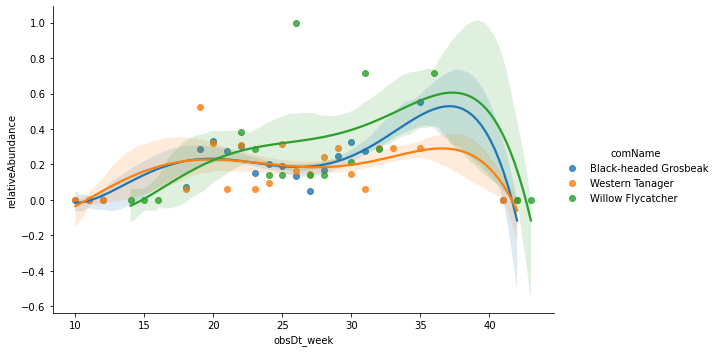

In [646]:
model___summerFall = wklyAbd_setSpecies(speciesList=['"Western Tanager"','"Black-headed Grosbeak"','"Willow Flycatcher"'])
sns.lmplot(data=model___summerFall,x='obsDt_week',y='relativeAbundance',order=5,ci=65,hue='comName',aspect=1.61)

C:\Users\lukew\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


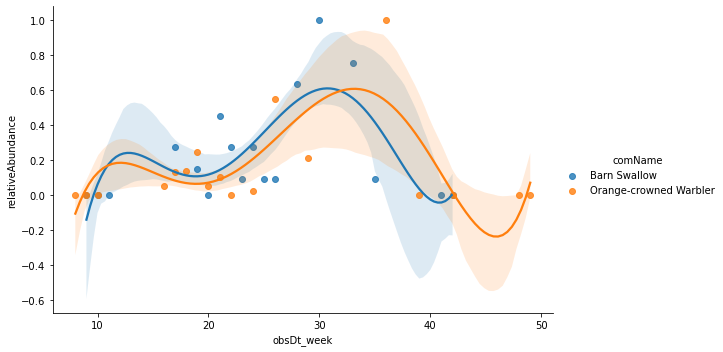

In [647]:
model___springFall = wklyAbd_setSpecies(speciesList=['"Orange-crowned Warbler"','"Barn Swallow"'])
sns.lmplot(data=model___springFall,x='obsDt_week',y='relativeAbundance',order=5,ci=65,hue='comName',aspect=1.61)


C:\Users\lukew\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


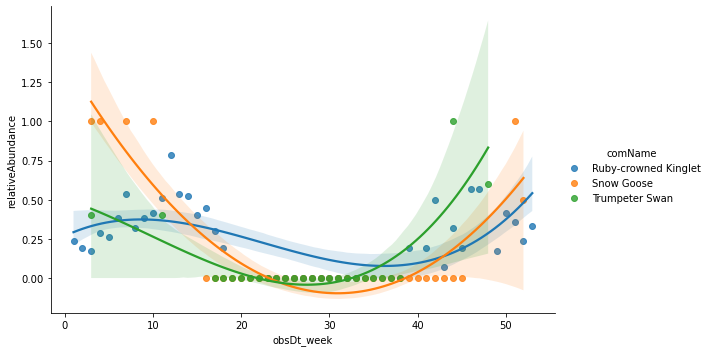

In [641]:
model___winter = wklyAbd_setSpecies(speciesList=['"Ruby-crowned Kinglet"','"Trumpeter Swan"','"Snow Goose"'])
sns.lmplot(data=model___winter,x='obsDt_week',y='relativeAbundance',order=3,ci=85,hue='comName',aspect=1.61)

Forecasting Architecture:

The interpolation needs of this dataset are sending the project shuffling closer to the neural network center.

- Reference models group birds based on expressed habitat preference, seasonality and rolling volume. Where neccessary, linear interpolation is applied to the reference models to reasonabily fill in gaps. The strength (re:limit value) of this interpolation and the accompanying mask is determined by rarity. Each bird+stop combination is assigned a reference model.
- R-squared testing assigns an interpolation method to each bird+stop combination to estimate the relative abundance of a bird at each stop based off of the given relative abundance and the reference model group
- Dependent forecasting uses existing relative abundance values to make inferences about relative abundance and habitat preference using a baseline of known values/sightings
- Independent forecasting projects the habitat preference of each bird over the habitat makeup of each stop, ignoring the sightings used to confirm the dependent forecasting model. For example: although there are not any Canada Jay sightings logged at Mt. Si, the habitat makeup of that stop correlates (Spearman rank) with the Canada Jay's preferred late-season habitat

In [ ]:
##TODO #77 identify birds that express seasonality/can only be found in the observed regions during specific times of year to inform the method of interpolation

In [369]:
##TODO #79 add 'StopName' as a loop layer to the relative abundance forecasting --DONE
def forecast_weeklyAbd():
    realObsAbd = weeklyAbundance()
    try:
        keyList = realObsAbd.drop_duplicates(subset=['comName','StopName'])
        realObsAbd = realObsAbd.groupby(['comName','StopName','obsDt_week'])['relativeAbundance'].mean().reset_index()
        forecastList = []
        for comName in keyList.itertuples():
            #species = pd.DataFrame(keyList[keyList['comName'] == comName.comName])
            obsAbd = realObsAbd[realObsAbd['comName'] == comName.comName]
            obsAbd = obsAbd[obsAbd['StopName'] == comName.StopName]
    #build presence time series scope
            weekMin = (obsAbd['obsDt_week'].min()-8)
            if weekMin <= 0: weekMin = 1
            weekMax = (obsAbd['obsDt_week'].max()+8)
            if weekMax > 53: weekMax = 53
            allweek = pd.DataFrame({'obsDt_week':range(weekMin,weekMax)})
            obsAbd.drop(columns=['comName','StopName'],inplace=True)
            ptForxt = pd.merge(left=obsAbd,right=allweek,left_on='obsDt_week',right_on='obsDt_week',how='outer')
            ptForxt.set_index('obsDt_week',inplace=True)
            ptForxt.sort_index(axis='index',ascending=True,inplace=True)
    #mask in seasonality, where there are no birds present in the observed location
            ptForxt['mask'] = ptForxt['relativeAbundance'].interpolate(method='index',limit=5,limit_direction='both')  #mask, values do not matter
            ptForxt.loc[ptForxt['mask'].isna() == True,'relativeAbundance'] = 0
            ptForxt['forecastAbd'] = ptForxt['relativeAbundance'].interpolate(method='polynomial',order=5,limit=5,limit_direction='both')   #real forecast
            ptForxt['comName'] = comName.comName
            ptForxt['StopName'] = comName.StopName
            ptForxt = ptForxt.reset_index()
            forecastList.append(ptForxt)
        seasonalAbd = pd.DataFrame()
        seasonalAbd = pd.DataFrame(pd.concat(forecastList,ignore_index=True))
    except Exception as abdForxExc:
        raise abdForxExc
    return seasonalAbd

In [370]:
forx = forecast_weeklyAbd()

In [390]:
##TODO #78 calculate R2 scores for each relative abundance interpolation method

forecast = forx[['comName','StopName','obsDt_week','relativeAbundance']]
forecast = forecast[forecast['comName']=='Canada Jay']
forecast = forecast[forecast['StopName']=='ChiricoTrail_PooPooPoint']
forecast.set_index('obsDt_week',inplace=True)


In [381]:
from sklearn.metrics import r2_score

In [403]:
forecast = forecast.assign(fillMean=forecast.relativeAbundance.fillna(forecast.relativeAbundance.mean()))
forecast = forecast.assign(fillMedian=forecast.relativeAbundance.fillna(forecast.relativeAbundance.median()))
forecast = forecast.assign(linear=forecast.relativeAbundance.interpolate(method='linear',limit=5,limit_direction='both'))
forecast = forecast.assign(splineThree=forecast.relativeAbundance.interpolate(method='spline',order=3,limit=5,limit_direction='both'))
forecast = forecast.assign(polynomialThree=forecast.relativeAbundance.interpolate(method='polynomial',order=3,limit=5,limit_direction='both'))
forecast = forecast.assign(polynomialFive=forecast.relativeAbundance.interpolate(method='polynomial',order=5,limit=5,limit_direction='both'))

In [405]:
results = [(method,r2_score(forecast.linear,forecast[method])) for method in list(forecast)[6:]]
results_df = pd.DataFrame(np.array(results),columns=['Method','r_squared'])
results_df.sort_values(by='r_squared',ascending=False)
results_df

,Method,r_squared
0,linear,1.0
1,splineThree,0.43094248847845873
2,splineFive,-32.29752234089802
3,polynomialThree,-8.878357622059019
4,polynomialFive,-32.29752234089802


In [ ]:
##TODO #66 split out birds into quartiles based on the number of observations available and the YOY frequency. Results will determine the strength of forecasting required

In [406]:
##TODO #64 using the relative abundance value from weeklyAbundance(), write a function that returns FAO land coverage preference --DONE
##TODO #68 add seasons to relative abundance function, then add in a loop over each season in the function seasonalHabitatPreference
def seasonalHabitatPref():
    cnx = connectDB()
    try:
        wklyAbd = weeklyAbundance()
        #start season loop here
        rawList = []
        for locId in wklyAbd.itertuples():
            query = f'SELECT Barren,Urban,Grasslands,Savannas,waterBodies,evergreenNeedleleafForest,evergreenBroadleafForests,openForests,mixedBroadleafandNeedleleafForests,sparseForests,denseHerbaceous,sparseHerbaceous FROM FAO_by_locId WHERE FAO_by_locId.locId = "{locId.locId}"'
            lx = pd.read_sql(query,con=cnx)
            lx = lx.applymap(lambda x: locId.relativeAbundance*x,na_action='ignore')
            lx = lx.assign(comName=locId.comName)
            lx = lx.assign(obsDt_week=locId.obsDt_week)
            #lx['comName'] = locId.comName
            #lx['obsDt_week'] = locId.obsDt_week
            rawList.append(lx)
        results = pd.DataFrame()
        results = pd.concat(rawList,ignore_index=True)
        results = results.groupby(['comName','obsDt_week']).mean()
        results.reset_index(inplace=True)
        results = pd.DataFrame(results)
    except Exception as prefExc:
        raise UserWarning(prefExc)
    finally: cnx.close()
    return results

In [103]:
##TODO #65 using historic habitat preference data, forecast the seasonal habitat preference for each species of bird --DONE
##TODO #74 update the interpolation method used in forecasting habitat preference to polynomial or just use the forecasted relative abundance
def forecastHabtPref():
    realHabtPref = seasonalHabitatPref()
    habtKeys = realHabtPref.drop_duplicates(subset=['comName'])
    try:
        forxHabtList = []
        for i in habtKeys.itertuples():
            allweek = pd.DataFrame({'obsDt_week':range(1,53)})
            obsPref = realHabtPref[realHabtPref['comName'] == i.comName]
            obsPref.drop(columns=['comName'],inplace=True)
            forxPref = pd.merge(left=obsPref,right=allweek,left_on='obsDt_week',right_on='obsDt_week',how='outer')
            forxPref.set_index('obsDt_week',inplace=True)
            forxPref.sort_index(axis='index',ascending=True,inplace=True)
            #forxPref.interpolate(method='polynomial',order=3,inplace=True,limit=3,limit_direction='both')
            forxPref.interpolate(method='linear',inplace=True,limit=3,limit_direction='both')
            forxPref['comName'] = i.comName
            forxPref = forxPref.reset_index()
            forxHabtList.append(forxPref)
        forecastPref = pd.DataFrame()
        forecastPref = pd.concat(forxHabtList,ignore_index=True)
    except Exception as habtPrefForxExcp:
        raise UserWarning(habtPrefForxExcp)
    return forecastPref

In [ ]:
##TODO #65 using historic habitat preference data, forecast the seasonal habitat preference for each species of bird --DONE
##TODO #74 update the interpolation method used in forecasting habitat preference to polynomial or just use the forecasted relative abundance
def forecastHabtPref():
    realHabtPref = seasonalHabitatPref()
    habtKeys = realHabtPref.drop_duplicates(subset=['comName'])
    try:
        forxHabtList = []
        for i in habtKeys.itertuples():
            allweek = pd.DataFrame({'obsDt_week':range(1,53)})
            obsPref = realHabtPref[realHabtPref['comName'] == i.comName]
            obsPref.drop(columns=['comName'],inplace=True)
            forxPref = pd.merge(left=obsPref,right=allweek,left_on='obsDt_week',right_on='obsDt_week',how='outer')
            forxPref.set_index('obsDt_week',inplace=True)
            forxPref.sort_index(axis='index',ascending=True,inplace=True)
            #forxPref.interpolate(method='polynomial',order=3,inplace=True,limit=3,limit_direction='both')
            forxPref.interpolate(method='linear',inplace=True,limit=3,limit_direction='both')
            forxPref['comName'] = i.comName
            forxPref = forxPref.reset_index()
            forxHabtList.append(forxPref)
        forecastPref = pd.DataFrame()
        forecastPref = pd.concat(forxHabtList,ignore_index=True)
    except Exception as habtPrefForxExcp:
        raise UserWarning(habtPrefForxExcp)
    return forecastPref

In [104]:
forgex = forecastHabtPref()
forgex

C:\Users\lukew\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,obsDt_week,Urban,Savannas,evergreenNeedleleafForest,evergreenBroadleafForests,openForests,mixedBroadleafandNeedleleafForests,sparseForests,comName
0,1,NaN,NaN,0.010000,NaN,NaN,0.067692,NaN,Canada Jay
1,2,NaN,NaN,0.060171,NaN,NaN,0.067692,NaN,Canada Jay
2,3,NaN,NaN,0.110342,NaN,NaN,0.067692,NaN,Canada Jay
3,4,NaN,NaN,0.160513,NaN,NaN,0.067692,NaN,Canada Jay
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada Jay
...,...,...,...,...,...,...,...,...,...
100,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Orange-crowned Warbler
101,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Orange-crowned Warbler
102,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Orange-crowned Warbler
103,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Orange-crowned Warbler
